In [1]:
import torch
import matplotlib.pyplot as plt
import gpytorch
import numpy as np
import datetime as dt

#get_ipython().run_line_magic('matplotlib', 'notebook')
#get_ipython().run_line_magic('matplotlib', 'inline')
#get_ipython().run_line_magic('load_ext', 'autoreload')
#get_ipython().run_line_magic('autoreload', '2')


In [2]:
import pandas as pd
#df = pd.read_csv('Case3_2nd_launch_WingsConvCoeffs_Info.csv', sep=";")
df = pd.read_excel('Case5_1st_launch_WingsConvCoeffs_Info.xlsx')
df_conv = df[df['Unnamed: 47'] == 'CONVERGED']
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_conv, test_size=0.2, random_state=42 )

In [3]:
#df1 = df[df['Sales'] >= s] 
train_conv = train[train['Unnamed: 47'] == 'CONVERGED']
test_conv = train[train['Unnamed: 47'] == 'CONVERGED']
train.head()
train_conv.head()

,#nWings,aws,awa,alpha0,alpha1,alpha2,alpha3,center0,center1,center2,...,Cy2Var,Cm2Mean,Cm2Var,Cx3Mean,Cx3Var,Cy3Mean,Cy3Var,Cm3Mean,Cm3Var,Unnamed: 47
1288,4,14.3,30.1,3,-2,0,-5,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000212,-0.492588,0.000053,0.819482,0.000071,1.971543,0.000067,-0.419847,0.000020,CONVERGED
645,4,14.3,30.1,1,0,0,-11,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000003,-0.500426,0.000001,1.030776,0.000003,2.503144,0.000004,-0.446829,0.000001,CONVERGED
92,4,14.3,30.1,-1,-4,-6,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000004,-0.542092,0.000002,1.077446,0.000003,2.775430,0.000004,-0.455870,0.000002,CONVERGED
816,4,14.3,30.1,-5,-2,-2,-9,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000005,-0.516340,0.000002,0.909318,0.000005,2.267886,0.000005,-0.434650,0.000002,CONVERGED
163,4,14.3,30.1,-3,-4,-2,-15,"(20,9.901,0)","(68,9.901,0)","(20,-9.901,0)",...,0.000003,-0.527225,0.000001,1.096549,0.000005,2.792376,0.000005,-0.456825,0.000002,CONVERGED


In [4]:
train_x = train.alpha0.to_numpy()
test_x  = test.alpha0.to_numpy()
#train_y = train.Cy0Mean.to_numpy()
#test_y  = test.Cy0Mean.to_numpy()

# normalize features
mean = train_x.mean( )
std = train_x.std( ) + 1e-6 # prevent dividing by 0
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

# normalize labels
#mean, std = train_y.mean(),train_y.std()
#train_y = (train_y - mean) / std
#test_y = (test_y - mean) / std

# make continguous
#train_x, train_y = train_x.contiguous(), train_y.contiguous()
#test_x, test_y = test_x.contiguous(), test_y.contiguous()

# Cast them
X_train = torch.FloatTensor(train_x.squeeze())
X_test = torch.FloatTensor(test_x.squeeze())
#Y_train = torch.FloatTensor(train_y.squeeze())
#Y_test = torch.FloatTensor(test_y.squeeze())


"""
normalized = True 
if normalized:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df.awa.to_numpy().reshape(-1, 1))

    Xn_train = scaler.transform(train.awa.to_numpy().reshape(-1, 1))
    Xn_test = scaler.transform(test.awa.to_numpy().reshape(-1, 1))
    
    X_train = torch.FloatTensor(Xn_train.squeeze())
    X_test = torch.FloatTensor(Xn_test.squeeze())

else:
    X_train = torch.FloatTensor(train.awa.to_numpy())
    X_test = torch.FloatTensor(test.awa.to_numpy())
"""

#X_train = torch.FloatTensor((train.awa.to_numpy()))
Y_train = torch.FloatTensor(train.Cy0Mean.to_numpy()) #,df.Cy0Mean.to_numpy(),df.Cm0Mean.to_numpy()
#X_test = torch.FloatTensor(test.awa.to_numpy())
Y_test = torch.FloatTensor(test.Cy0Mean.to_numpy())

# = torch.FloatTensor(np.vstack((train.awa.to_numpy(),train.alpha0.to_numpy()))).T

In [5]:
# Define the Kernel of GP
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        # this serve for prior
        #self.mean_module = gpytorch.means.ZeroMean()
        #PeriodicKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #RQKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        #self.covar_module = gpytorch.kernels.ProductKernel(PeriodicKernel,RQKernel)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [6]:
## FIT THE MODEL.. change X train and Y train with a subset ..

#likelihood = gpytorch.likelihoods.GaussianLikelihood()
noise_level = 0.01
noise = noise_level*torch.ones(X_train.shape[0])
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise, learn_additional_noise=False)

model = ExactGPModel(X_train, Y_train, likelihood)

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters())  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter  = 500
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train)
    loss.backward()
    if (i+1) % 100 == 0:
        print('Iter {}/{} - Loss: {} LenghtParam {} '.format(
            i + 1, training_iter, loss.item(), model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0] ))
    optimizer.step()

Iter 100/500 - Loss: -1.1649982929229736 LenghtParam 0.7418369650840759 
Iter 200/500 - Loss: -1.1711368560791016 LenghtParam 0.7937038540840149 
Iter 300/500 - Loss: -1.1728099584579468 LenghtParam 0.8474373817443848 
Iter 400/500 - Loss: -1.165879487991333 LenghtParam 0.9020585417747498 
Iter 500/500 - Loss: -1.1729005575180054 LenghtParam 0.960691511631012 


c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


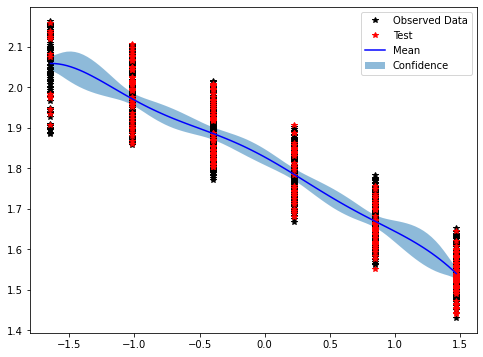

In [8]:
model.eval()
likelihood.eval()
#test_x = torch.FloatTensor(np.linspace(X_train.min(),X_train.max(),100))
test_x = torch.linspace(X_train.min(), X_train.max(), 100)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(test_x)
    Y_mean = f_preds.mean
    Y_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(test_x))
     # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    
    ax.plot(X_train.numpy(), Y_train.numpy(), 'k*')
    ax.plot(X_test.numpy(), Y_test.numpy(), 'r*')

    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data','Test', 'Mean', 'Confidence'])
